In [1]:
from cohirf.experiment.open_ml_clustering_experiment import OpenmlClusteringExperiment
from cohirf.experiment.hpo_open_ml_clustering_experiment import HPOOpenmlClusteringExperiment
import numpy as np
from pathlib import Path
from ml_experiments.utils import unflatten_any
from graphviz import Digraph

In [2]:
def create_cluster_graph(clusters_iter, title="Hierarchical Clustering", simplified=False, min_samples=2):
    """
    Create a graphviz visualization of the hierarchical clustering.
    
    Parameters:
    - clusters_iter: Dictionary with structure clusters_iter[iteration][representative]
    - title: Title for the graph
    - simplified: Boolean to create simplified version (default: False)
    - min_samples: Minimum samples per cluster for simplified version (default: 2)
    
    Returns:
    - graphviz Source object
    """
    # Filter clusters if simplified version is requested
    if simplified:
        filtered_clusters = {}
        for iter_num, clusters in clusters_iter.items():
            filtered_clusters[iter_num] = {}
            for rep_id, cluster_info in clusters.items():
                if len(cluster_info['samples']) >= min_samples:
                    filtered_clusters[iter_num][rep_id] = cluster_info
        working_clusters = filtered_clusters
    else:
        working_clusters = clusters_iter

    # Create a new directed graph
    dot = Digraph(comment=title)

    # Set attributes based on version
    if simplified:
        dot.attr(rankdir='TB', splines='true', nodesep='0.2', ranksep='1.0')
        dot.attr('node', shape='circle', style='filled')
        default_fontsize = '12'
        default_width = '1.5'
        default_height = '1.5'
        arrow_size = '0.7'
        transparency_suffix = 'AA'
    else:
        dot.attr(rankdir='TB', splines='true', nodesep='0.5', ranksep='1.0')
        dot.attr('node', shape='circle', style='filled')
        default_fontsize = '7'
        default_width = '1.2'
        default_height = '1.2'
        arrow_size = '0.5'
        transparency_suffix = '80'

    # Color palette for different classes
    class_colors = {
        'Iris-setosa': '#FF6B6B',      # Red
        'Iris-versicolor': '#4ECDC4',   # Teal
        'Iris-virginica': '#45B7D1',    # Blue
    }

    # Process each iteration (level)
    for iter_num in sorted(working_clusters.keys()):
        if simplified and not working_clusters[iter_num]:  # Skip empty iterations in simplified mode
            continue

        # Create a subgraph for this iteration to keep nodes at the same level
        with dot.subgraph() as s:
            s.attr(rank='same')

            for rep_id, cluster_info in working_clusters[iter_num].items():
                node_id = cluster_info['name']
                class_counts = cluster_info['class_counts']
                total_samples = len(cluster_info['samples'])

                # Build label text based on version
                if simplified:
                    label_parts = []

                    # Add class counts with percentages
                    for class_name, count in class_counts.items():
                        if count > 0:
                            percentage = (count / total_samples) * 100
                            label_parts.append(f"{class_name.split('-')[-1]}: {count} ({percentage:.0f}%)")
                else:
                    label_parts = [f"Iter {iter_num}"]
                    label_parts.append(f"Rep: {rep_id}")
                    label_parts.append(f"Size: {total_samples}")
                    label_parts.append("")  # Empty line for separation

                    # Add class counts
                    for class_name, count in class_counts.items():
                        if count > 0:
                            label_parts.append(f"{class_name}: {count}")

                label = "\\n".join(label_parts)

                # Determine node color based on dominant class
                if len(class_counts) > 0:
                    dominant_class = class_counts.idxmax()
                    node_color = class_colors.get(dominant_class, '#DDDDDD')

                    # Adjust color intensity based on purity
                    purity = class_counts[dominant_class] / class_counts.sum()
                    if purity < 0.8:
                        node_color = node_color + transparency_suffix  # Add transparency
                else:
                    node_color = '#DDDDDD'

                # Add node with bold text
                s.node(node_id, label=label, fillcolor=node_color, 
                      fontsize=default_fontsize, width=default_width, height=default_height,
                      fontname='Arial Bold')

    # Add edges between iterations
    for iter_num in sorted(working_clusters.keys()):
        for rep_id, cluster_info in working_clusters[iter_num].items():
            if 'next_cluster' in cluster_info:
                next_cluster_name = cluster_info['next_cluster']
                current_node = cluster_info['name']

                if simplified:
                    # Check if the next cluster exists in our filtered set
                    next_iter = iter_num + 1
                    if next_iter in working_clusters:
                        for next_rep_id, next_cluster_info in working_clusters[next_iter].items():
                            if next_cluster_info['name'] == next_cluster_name:
                                dot.edge(current_node, next_cluster_name, color='black', arrowsize=arrow_size)
                                break
                else:
                    dot.edge(current_node, next_cluster_name, color='black', arrowsize=arrow_size)

    return dot

In [3]:
def get_roots_from_parents(parents):
    # Find the root parent for each sample
    roots = np.arange(len(parents))
    while True:
        new_roots = parents[roots]
        if np.all(new_roots == roots):
            break
        roots = new_roots
    return roots

In [4]:
results_dir = Path("/home/belucci/code/cohirf/results") / "viz"
# results_dir = Path("/home/users/belucci/cohirf/results/viz")
results_dir.mkdir(parents=True, exist_ok=True)
mlflow_tracking_uri = f"sqlite:///{results_dir}/mlflow.db"
experiment_params = dict(
    mlflow_tracking_uri=mlflow_tracking_uri,
    check_if_exists=False,
	verbose=1,
)

# Kernel KMeans

In [3]:
experiment = HPOOpenmlClusteringExperiment(
    model="CoHiRF-KernelRBF",
    # model_params=model_params,
    # search_space=search_space,
    # default_values=default_values,
    hpo_seed=0,
    hpo_metric="adjusted_rand",
    direction="maximize",
    n_jobs=5,
    n_trials=100,
    # dataset
    dataset_id=61,  # OpenML dataset ID for "Iris"
    standardize=True,
    raise_on_error=True,
    **experiment_params,
)
results = experiment.run(return_results=True)
result = results[0]
best_ari = result["evaluate_model_return"]["best/adjusted_rand"]
print(f"Best ARI: {best_ari}")

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

2025/12/01 14:21:48 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/01 14:21:48 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

/home/belucci/code/cohirf/cohirf/experiment/clustering_experiment.py:27: UserWarning: Too many clusters (79) for dataset with 147 samples. Skipping metric calculation. If you want to calculate metrics anyway, set `calculate_metrics_even_if_too_many_clusters` to True.
  warn(f"Too many clusters ({n_clusters}) for dataset with {X.shape[0]} samples. Skipping metric calculation. If you want to calculate metrics anyway, set `calculate_metrics_even_if_too_many_clusters` to True.")
/home/belucci/code/ml_experiments/ml_experiments/tuners.py:233: UserWarning: metric adjusted_rand not found in dict returned by training_fn, available metrics are dict_keys(['n_clusters_', 'elapsed_time', 'seed_model'])
  warn(f'metric {metric} not found in dict returned by training_fn, available metrics are '
/home/belucci/code/cohirf/cohirf/experiment/clustering_experiment.py:27: UserWarning: Too many clusters (96) for dataset with 147 samples. Skipping metric calculation. If you want to calculate metrics anyway,

Best ARI: 0.9392271414220472


In [15]:
experiment = OpenmlClusteringExperiment(
    model="CoHiRF-KernelRBF",
    seed_model=result["evaluate_model_return"]["best/seed_model"],
    model_params=dict(
        unflatten_any(result["fit_model_return"]["study"].best_params),
        save_path=True,
    ),
    n_jobs=5,
    # dataset
    dataset_id=61,  # OpenML dataset ID for "Iris"
    standardize=True,
    raise_on_error=True,
    **experiment_params,
)
results = experiment.run(return_results=True)
result = results[0]
ari = result["evaluate_model_return"]["adjusted_rand"]
print(ari)

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

0.9392271414220472


In [ ]:
model = result["load_model_return"]["model"]
y = result["load_data_return"]["y"]
y = y.reset_index(drop=True)
parents = model.parents_.copy()
final_representatives = model.representatives_indexes_.copy()
representatives_iter = model.representatives_iter_

In [18]:
representatives_iter

[array([ 10,  92,  81, 136, 128,  47,  55, 104,  72, 131, 124, 110]),
 array([ 10, 110,  72, 128,  92, 124, 131, 104,  55]),
 array([124, 131, 104,  92, 110,  10]),
 array([104,  92,  10, 124, 110]),
 array([ 92,  10, 124]),
 array([ 10,  92, 124])]

In [19]:
[len(r) for r in representatives_iter]

[12, 9, 6, 5, 3, 3]

In [21]:
clusters_iter = {}
parents = model.parents_.copy()
for i in range(len(representatives_iter)):
    iter = len(representatives_iter) - 1 - i
    clusters_iter[iter] = {}
    # from last to first
    representatives = representatives_iter[iter]  
    # replace parents with their representatives in this iteration
    parents[representatives] = representatives
    roots = get_roots_from_parents(parents)
    unique_roots = np.unique(roots)
    for root in unique_roots:
        clusters_iter[iter][root] = {"samples": np.where(roots == root)[0]}
        clusters_iter[iter][root]["class_counts"] = y[clusters_iter[iter][root]["samples"]].value_counts()
        clusters_iter[iter][root]["name"] = f"cluster_iter_{iter}_{root}"

for i in range(len(representatives_iter) - 1):
    for rep, cluster in clusters_iter[i].items():
        # find where rep is in the next level
        for next_rep, next_cluster in clusters_iter[i + 1].items():
            if rep in next_cluster["samples"]:
                clusters_iter[i][rep]["next_cluster"] = f"cluster_iter_{i + 1}_{next_rep}"
                break

In [22]:
clusters_iter

{5: {np.int64(10): {'samples': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
          17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
          34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
   'class_counts': class
   Iris-setosa        48
   Iris-versicolor     0
   Iris-virginica      0
   Name: count, dtype: int64,
   'name': 'cluster_iter_5_10'},
  np.int64(92): {'samples': array([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
          65, 66, 67, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 82, 83, 84,
          85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
   'class_counts': class
   Iris-versicolor    47
   Iris-setosa         0
   Iris-virginica      0
   Name: count, dtype: int64,
   'name': 'cluster_iter_5_92'},
  np.int64(124): {'samples': array([ 68,  75,  81,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
          108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
 

In [23]:
# Examine the structure of clusters_iter
print("Number of iterations:", len(clusters_iter))
for iter_num in sorted(clusters_iter.keys()):
    print(f"Iteration {iter_num}: {len(clusters_iter[iter_num])} clusters")
    for rep_id, cluster_info in list(clusters_iter[iter_num].items())[:2]:  # Show first 2 clusters
        print(f"  Cluster {rep_id}:")
        print(f"    Name: {cluster_info['name']}")
        print(f"    Samples: {len(cluster_info['samples'])} items")
        print(f"    Class counts: {dict(cluster_info['class_counts'])}")
        if 'next_cluster' in cluster_info:
            print(f"    Next cluster: {cluster_info['next_cluster']}")
        print()

Number of iterations: 6
Iteration 0: 12 clusters
  Cluster 10:
    Name: cluster_iter_0_10
    Samples: 11 items
    Class counts: {'Iris-setosa': np.int64(11), 'Iris-versicolor': np.int64(0), 'Iris-virginica': np.int64(0)}
    Next cluster: cluster_iter_1_10

  Cluster 47:
    Name: cluster_iter_0_47
    Samples: 37 items
    Class counts: {'Iris-setosa': np.int64(37), 'Iris-versicolor': np.int64(0), 'Iris-virginica': np.int64(0)}
    Next cluster: cluster_iter_1_10

Iteration 1: 9 clusters
  Cluster 10:
    Name: cluster_iter_1_10
    Samples: 48 items
    Class counts: {'Iris-setosa': np.int64(48), 'Iris-versicolor': np.int64(0), 'Iris-virginica': np.int64(0)}
    Next cluster: cluster_iter_2_10

  Cluster 55:
    Name: cluster_iter_1_55
    Samples: 5 items
    Class counts: {'Iris-versicolor': np.int64(5), 'Iris-setosa': np.int64(0), 'Iris-virginica': np.int64(0)}
    Next cluster: cluster_iter_2_92

Iteration 2: 6 clusters
  Cluster 10:
    Name: cluster_iter_2_10
    Samples: 48

In [25]:
# Create both full and simplified graph visualizations
# Full version
graph = create_cluster_graph(clusters_iter, "CoHiRF Hierarchical Clustering - Iris Dataset", simplified=False)

# Simplified version  
simplified_graph = create_cluster_graph(clusters_iter, "Simplified CoHiRF Hierarchical Clustering - Iris Dataset", 
                                       simplified=True, min_samples=3)

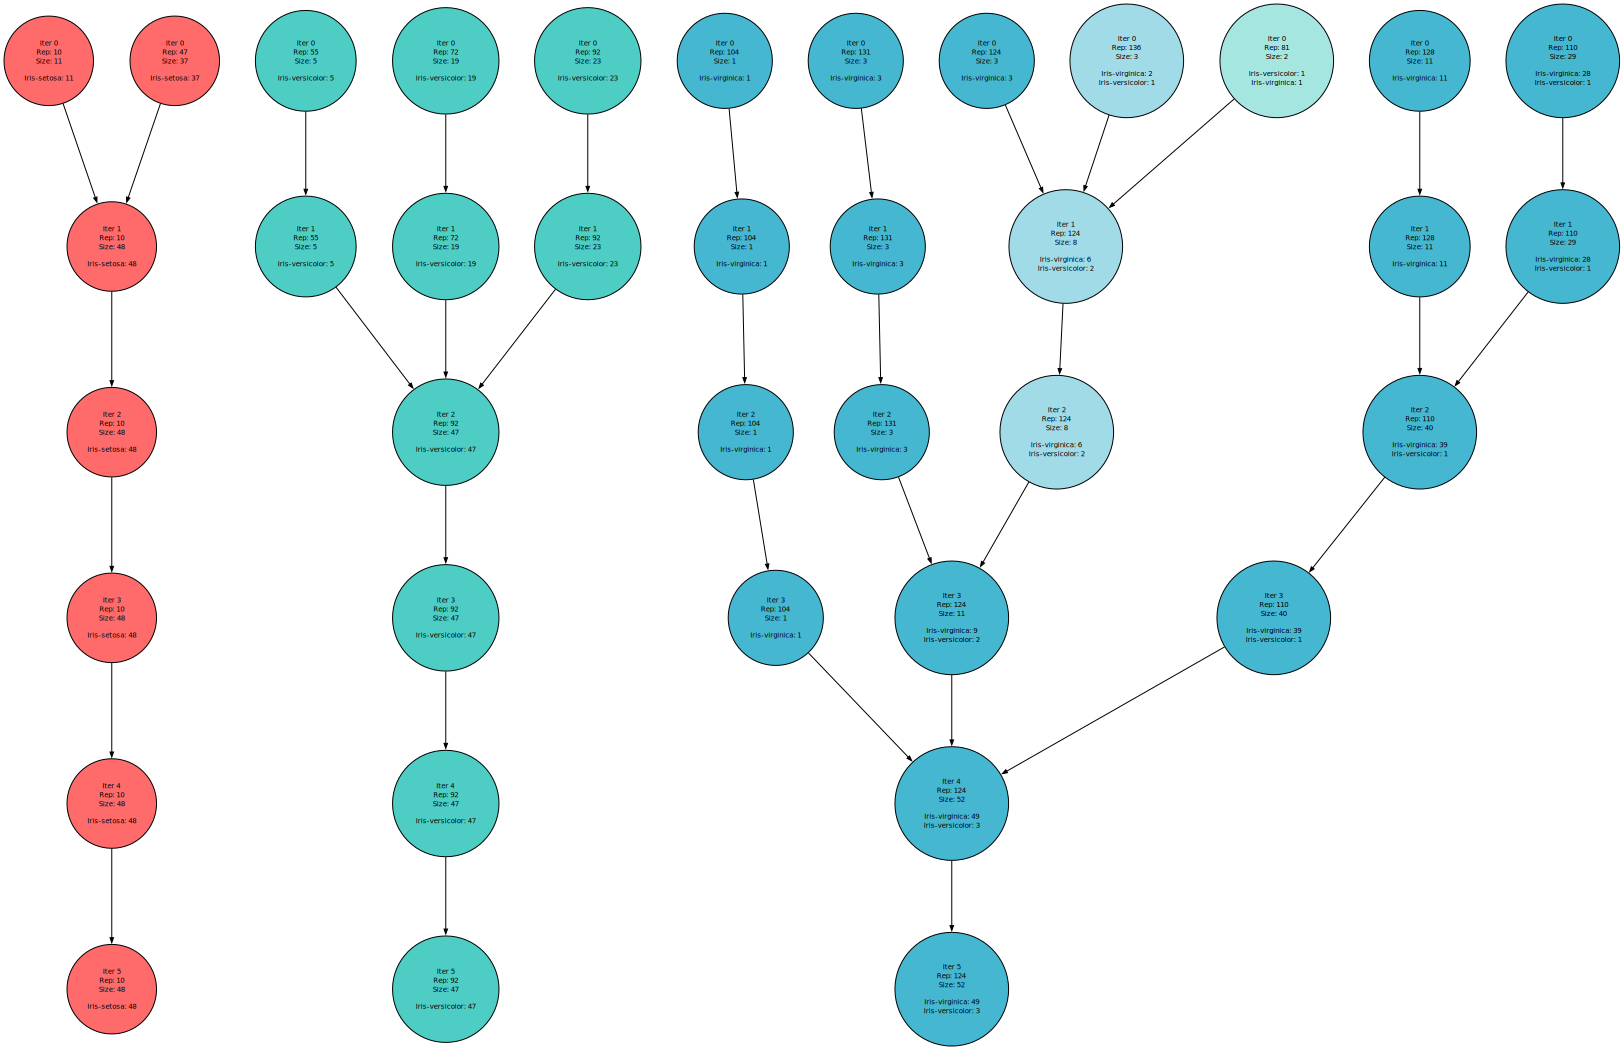

In [26]:
graph

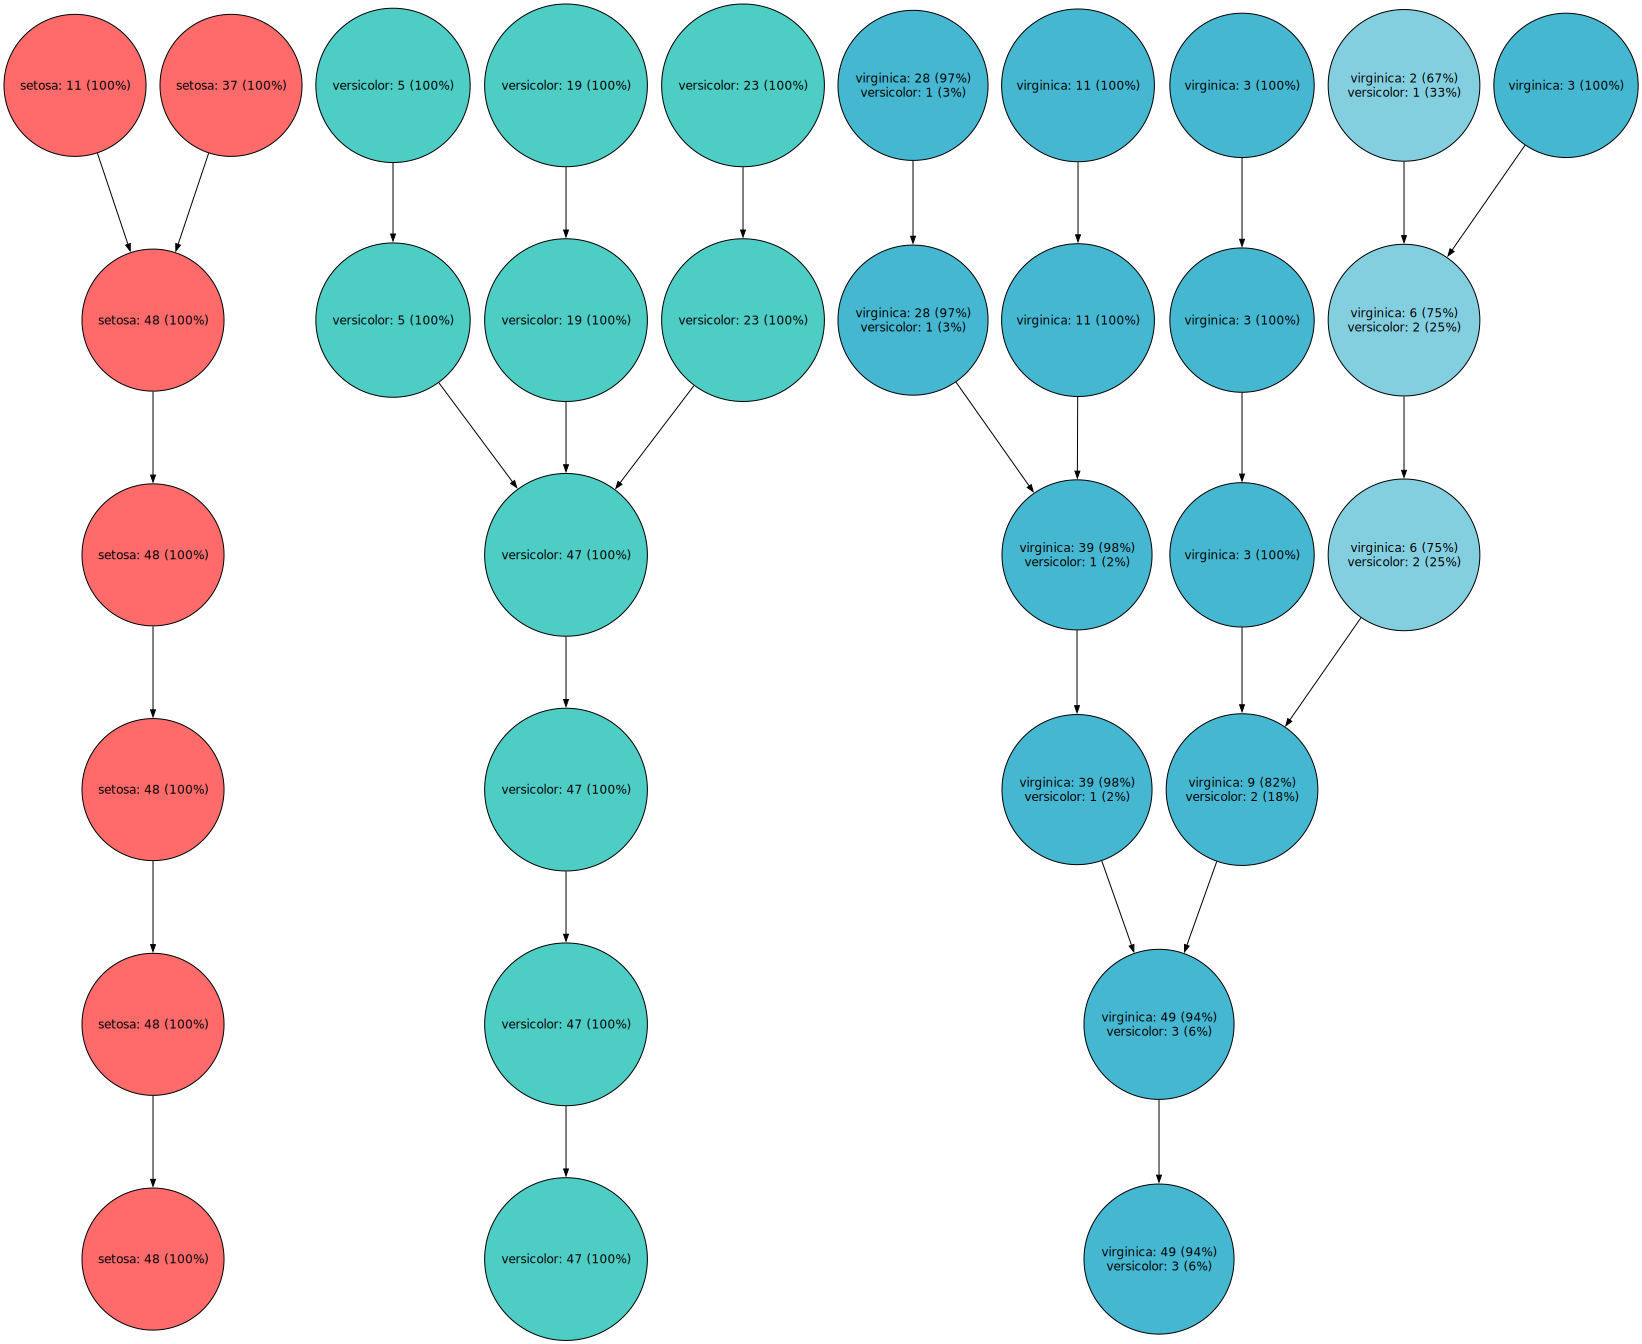

In [27]:
simplified_graph

In [29]:
# Save both graphs
graph_filename = results_dir / "hierarchical_clustering_graph_kkmeans"
simplified_filename = results_dir / "simplified_hierarchical_clustering_graph_kkmeans"

try:
    # Save full graph
    full_png = graph.render(filename=str(graph_filename), format='png', cleanup=True)
    full_pdf = graph.render(filename=str(graph_filename), format='pdf', cleanup=False)
    
    # Save simplified graph
    simplified_png = simplified_graph.render(filename=str(simplified_filename), format='png', cleanup=True)
    simplified_pdf = simplified_graph.render(filename=str(simplified_filename), format='pdf', cleanup=False)
    
    print("Graphs saved successfully:")
    print(f"Full graph:")
    print(f"  PNG: {full_png}")
    print(f"  PDF: {full_pdf}")
    print(f"Simplified graph:")
    print(f"  PNG: {simplified_png}")
    print(f"  PDF: {simplified_pdf}")
    
except Exception as e:
    print(f"Error rendering graphs: {e}")
    print("Graph objects created successfully, but rendering failed.")

Graphs saved successfully:
Full graph:
  PNG: /home/belucci/code/cohirf/results/viz/hierarchical_clustering_graph_kkmeans.png
  PDF: /home/belucci/code/cohirf/results/viz/hierarchical_clustering_graph_kkmeans.pdf
Simplified graph:
  PNG: /home/belucci/code/cohirf/results/viz/simplified_hierarchical_clustering_graph_kkmeans.png
  PDF: /home/belucci/code/cohirf/results/viz/simplified_hierarchical_clustering_graph_kkmeans.pdf


# SC-SRGF

In [5]:
experiment = HPOOpenmlClusteringExperiment(
    model="CoHiRF-SC-SRGF-1R",
    # model_params=model_params,
    # search_space=search_space,
    # default_values=default_values,
	seed_dataset_order=1,
    hpo_seed=1,
    hpo_metric="adjusted_rand",
    direction="maximize",
    n_jobs=5,
    n_trials=100,
    # dataset
    dataset_id=61,  # OpenML dataset ID for "Iris"
    standardize=True,
    raise_on_error=True,
    **experiment_params,
)
best_results = experiment.run(return_results=True)
best_result = best_results[0]
best_ari = best_result["evaluate_model_return"]["best/adjusted_rand"]
print(f"Best ARI: {best_ari}")

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

2025/12/01 14:48:23 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/01 14:48:23 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:370: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:370: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:370: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:370: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklear

Best ARI: 0.8823715293706086


In [6]:
experiment = OpenmlClusteringExperiment(
    model="CoHiRF-SC-SRGF-1R",
    seed_model=best_result["evaluate_model_return"]["best/seed_model"],
    model_params=dict(
        unflatten_any(best_result["fit_model_return"]["study"].best_params),
        save_path=True,
    ),
    seed_dataset_order=1,
    n_jobs=5,
    # dataset
    dataset_id=61,  # OpenML dataset ID for "Iris"
    standardize=True,
    raise_on_error=True,
    **experiment_params,
)
results = experiment.run(return_results=True)
result = results[0]
ari = result["evaluate_model_return"]["adjusted_rand"]
print(ari)

Combinations completed:   0%|          | 0/1 [00:00<?, ?it/s]

0.8823715293706086


/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:370: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  _, diffusion_map = eigsh(


In [9]:
model = result["load_model_return"]["model"]
y = result["load_data_return"]["y"]
y = y.reset_index(drop=True)
parents = model.parents_.copy()
final_representatives = model.representatives_indexes_.copy()
representatives_iter = model.representatives_iter_

In [10]:
clusters_iter = {}
parents = model.parents_.copy()
for i in range(len(representatives_iter)):
    iter = len(representatives_iter) - 1 - i
    clusters_iter[iter] = {}
    # from last to first
    representatives = representatives_iter[iter]
    # replace parents with their representatives in this iteration
    parents[representatives] = representatives
    roots = get_roots_from_parents(parents)
    unique_roots = np.unique(roots)
    for root in unique_roots:
        clusters_iter[iter][root] = {"samples": np.where(roots == root)[0]}
        clusters_iter[iter][root]["class_counts"] = y[clusters_iter[iter][root]["samples"]].value_counts()
        clusters_iter[iter][root]["name"] = f"cluster_iter_{iter}_{root}"

for i in range(len(representatives_iter) - 1):
    for rep, cluster in clusters_iter[i].items():
        # find where rep is in the next level
        for next_rep, next_cluster in clusters_iter[i + 1].items():
            if rep in next_cluster["samples"]:
                clusters_iter[i][rep]["next_cluster"] = f"cluster_iter_{i + 1}_{next_rep}"
                break

In [11]:
# Create both full and simplified graph visualizations
# Full version
graph = create_cluster_graph(clusters_iter, "CoHiRF Hierarchical Clustering - Iris Dataset", simplified=False)

# Simplified version
simplified_graph = create_cluster_graph(
    clusters_iter, "Simplified CoHiRF Hierarchical Clustering - Iris Dataset", simplified=True, min_samples=3
)

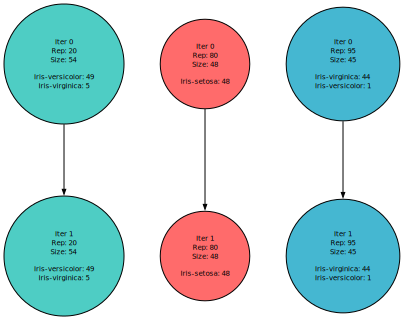

In [12]:
graph

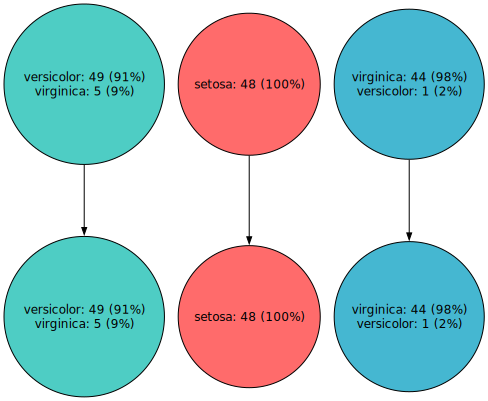

In [13]:
simplified_graph

In [14]:
# Save both graphs
graph_filename = results_dir / "hierarchical_clustering_graph_scsrgf"
simplified_filename = results_dir / "simplified_hierarchical_clustering_graph_scsrgf"

try:
    # Save full graph
    full_png = graph.render(filename=str(graph_filename), format="png", cleanup=True)
    full_pdf = graph.render(filename=str(graph_filename), format="pdf", cleanup=False)

    # Save simplified graph
    simplified_png = simplified_graph.render(filename=str(simplified_filename), format="png", cleanup=True)
    simplified_pdf = simplified_graph.render(filename=str(simplified_filename), format="pdf", cleanup=False)

    print("Graphs saved successfully:")
    print(f"Full graph:")
    print(f"  PNG: {full_png}")
    print(f"  PDF: {full_pdf}")
    print(f"Simplified graph:")
    print(f"  PNG: {simplified_png}")
    print(f"  PDF: {simplified_pdf}")

except Exception as e:
    print(f"Error rendering graphs: {e}")
    print("Graph objects created successfully, but rendering failed.")

Graphs saved successfully:
Full graph:
  PNG: /home/belucci/code/cohirf/results/viz/hierarchical_clustering_graph_scsrgf.png
  PDF: /home/belucci/code/cohirf/results/viz/hierarchical_clustering_graph_scsrgf.pdf
Simplified graph:
  PNG: /home/belucci/code/cohirf/results/viz/simplified_hierarchical_clustering_graph_scsrgf.png
  PDF: /home/belucci/code/cohirf/results/viz/simplified_hierarchical_clustering_graph_scsrgf.pdf
